In [100]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import models

In [144]:
import pathlib
dataset_url = "http://data.vicos.si/datasets/TRUNK12/TRUNK12.zip"
data_dir = tf.keras.utils.get_file('/root/.keras/datasets/TRUNK12',
                                   origin=dataset_url,  
                                   extract=True)
data_dir = pathlib.Path(data_dir)

In [145]:
data_dir

PosixPath('/root/.keras/datasets/TRUNK12')

In [146]:
data_dir = pathlib.Path("/root/.keras/datasets")

In [147]:
image_count = len(list(data_dir.glob('*/*.JPG')))
print(image_count)

393


In [69]:
#Parameters for the loader
batch_size = 32
img_height = 224
img_width = 224
learning_rate = 0.001
input_shape = (img_width, img_height, 3)

In [148]:
#Splitting training data 60%
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 393 files belonging to 12 classes.
Using 236 files for training.


In [149]:
#Splitting test/validation data 40%
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.4,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 393 files belonging to 12 classes.
Using 157 files for validation.


In [75]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [152]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of training batches: 8
Number of validation batches: 5
Number of test batches: 2


In [154]:
#We have 12 class names
class_names = train_dataset.class_names
print(class_names)

['alder', 'beech', 'birch', 'chestnut', 'ginkgo biloba', 'hornbeam', 'horse chestnut', 'linden', 'oak', 'oriental plane', 'pine', 'spruce']


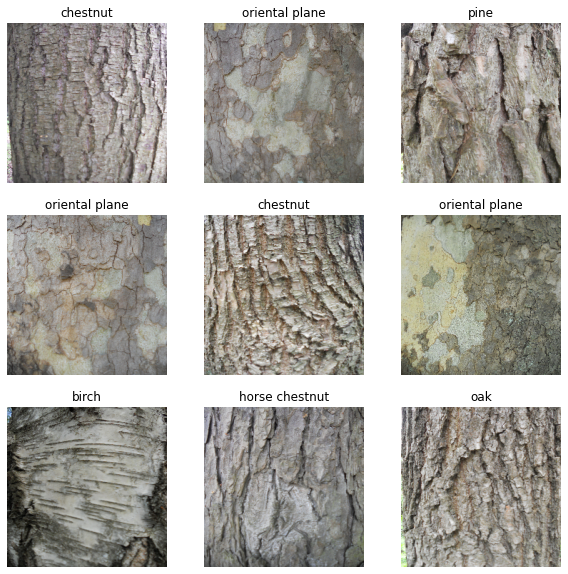

In [156]:
#class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

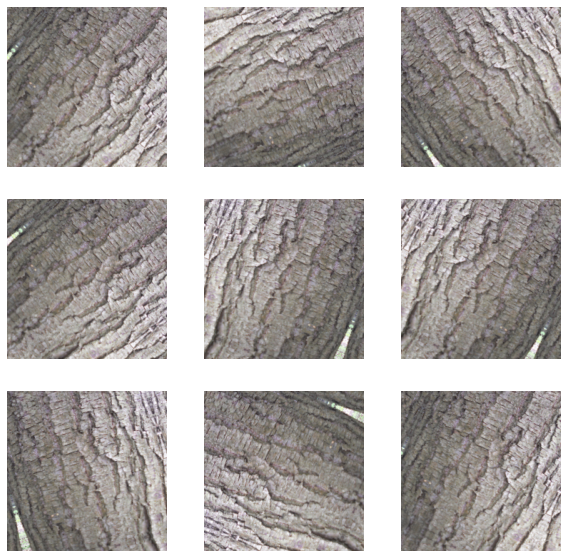

In [84]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [157]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')

In [158]:
base_model = models.Model(inputs=base_model.input, outputs=base_model.layers[-12].output)

In [178]:
#Data preprocessing 
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


In [160]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(image_batch.shape)
print(feature_batch.shape)

(32, 224, 224, 3)
(32, 7, 7, 160)


In [161]:
# Get the number of classes
class_names = train_dataset.class_names
num_classes = len(class_names)

In [171]:
# Freeze the convolutional base
base_model.trainable = False
average_pooling_layer = layers.GlobalAveragePooling2D()
fc_layer = layers.Dense(128, activation='relu')
prediction_layer = layers.Dense(num_classes, activation='softmax')

In [179]:
inputs = tf.keras.Input(shape=input_shape)
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = fc_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [181]:
model.summary()


Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv_9 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_9 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
model_7 (Functional)         (None, 7, 7, 160)         1364864   
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               20608     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0  

In [183]:
#Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['sparse_categorical_accuracy'])


In [169]:
len(model.trainable_variables)

4

In [184]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset, 
                    validation_steps=len(validation_dataset), 
                epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


8/8 [==============================] - 45s 3s/step - loss: 2.6442 - sparse_categorical_accuracy: 0.1610 - val_loss: 1.7262 - val_sparse_categorical_accuracy: 0.4777
Epoch 2/10
8/8 [==============================] - 40s 3s/step - loss: 1.5875 - sparse_categorical_accuracy: 0.5042 - val_loss: 1.1393 - val_sparse_categorical_accuracy: 0.7389
Epoch 3/10
8/8 [==============================] - 41s 3s/step - loss: 1.0359 - sparse_categorical_accuracy: 0.6822 - val_loss: 0.7759 - val_sparse_categorical_accuracy: 0.8089
Epoch 4/10
8/8 [==============================] - 41s 3s/step - loss: 0.6815 - sparse_categorical_accuracy: 0.8305 - val_loss: 0.5898 - val_sparse_categorical_accuracy: 0.8471
Epoch 5/10
8/8 [==============================] - 40s 3s/step - loss: 0.5066 - sparse_categorical_accuracy: 0.8559 - val_loss: 0.4568 - val_sparse_categorical_accuracy: 0.8726
Epoch 6/10
8/8 [==============================] - 41s 3s/step - loss: 0.3613 - sparse_categorical_accuracy: 0.9280 - val_loss: 0.38

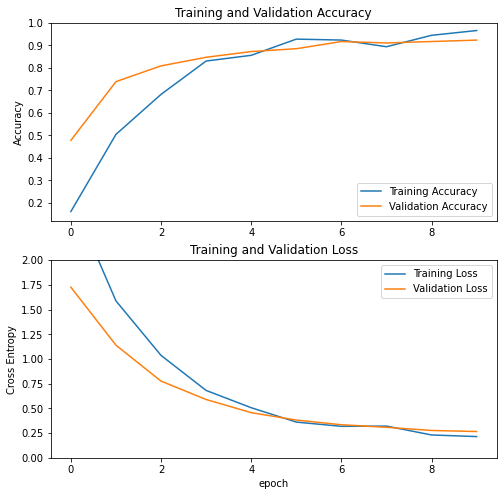

In [187]:
#Plot curves 
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [188]:
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy: ', test_acc)

2/2 [==============================] - 13s 889ms/step - loss: 0.2987 - sparse_categorical_accuracy: 0.9219
Test accuracy:  0.921875
